## NASA Earthdata Login Required
An Earthdata account is required to access data through the Soil Moisture Visualizer (SMV). Run the cell below to be prompted for your username and password. A link will be displayed for new users to register an account:

In [29]:
#from earthdata_login_jupyter import *

import requests
import getpass
from IPython.display import clear_output, HTML


class EarthdataLogin(requests.Session):
    """
    Prompt user for Earthdata credentials repeatedly until auth success. Test
    by attempting to download 44kb Daymet granule. Source:
    https://wiki.earthdata.nasa.gov/display/EL/How+To+Access+Data+With+Python
    """

    AUTH_HOST = "urs.earthdata.nasa.gov"             # urs login url
    
    ERROR = "Login failed ({0}). Retry or register." # failure message
    
    TEST = ("https://daac.ornl.gov/daacdata/daymet/" # ORNL DAAC Daymet
            "Daymet_V3_Annual_Climatology/data/"     # granule to touch to
            "daymet_v3_prcp_annttl_2017_pr.tif")     # test authentication; 
    
    REGISTER = HTML(                                 # registration prompt
        "<p style='font-weight:bold'><a href=https://urs.earthdata.nasa.gov"
        "/users/new>Click here to register an Earthdata account.</a></p>")
                              
    
    def __init__(self):
        super().__init__() 
        fails = 0
        
        while True:
            display(self.REGISTER)                    # register prompt
            
            username = input("Username: ")            # prompt for username
            password = getpass.getpass("Password: ")  # secure prompt for pw
            
            super().__init__()                        # init requests session
            self.auth = (username, password)          # add user,pw
            
            try:                                     
                response = self.get(self.TEST)        # try to grab TEST
                response.raise_for_status()           # raise for status>400
                clear_output()                        # clear output
                display("Login successful. Download with `session.get(url)`.")
                break

            except requests.exceptions.HTTPError as e:
                fails += 1                            # +1 fail
                clear_output()                        # clear cell output
                display(self.ERROR.format(str(fails)))# print failure msg

    
    def rebuild_auth(self, prepared_request, response):
        """
        Overrides from the library to keep headers when redirected to or 
        from the NASA auth host.
        """
        
        headers = prepared_request.headers
        url = prepared_request.url
 
        if 'Authorization' in headers:
            original_parsed = requests.utils.urlparse(response.request.url)
            redirect_parsed = requests.utils.urlparse(url)
            
            if (original_parsed.hostname != redirect_parsed.hostname) and \
                    redirect_parsed.hostname != self.AUTH_HOST and \
                    original_parsed.hostname != self.AUTH_HOST:
                del headers['Authorization']
                   
        #self.auth = None                    # purge username/password inputs
        return                              # return requests.Session object


### RUN ON IMPORT
session = EarthdataLogin()

'Login successful. Download with `session.get(url)`.'

In [33]:
url_test = "https://daac.ornl.gov/cgi-bin/viz/download.pl?lt=32.0802909170736&ln=-110.02593360995849&d=smap"
r = requests.get(url_test, cookies=auth)
r.content

b"Filename: daily-smap-ORNL-DAAC-XXXXXX\nData_Set_Name: Daily soil moisture and ancillary datasets. Data columns are delineated by commas. The values in each column when separated by semicolons represent the daily range as 'min; mean; max'.\nLocation: 32.0802909170736, -110.02593360995849\nCitation: ORNL DAAC. 2017. Soil Moisture Visualizer. ORNL DAAC, Oak Ridge, Tennessee, USA. http://dx.doi.org/10.3334/ORNLDAAC/1366\n\n\ntime,SoilSCAPE_surface,SoilSCAPE_rootzone,AirMOSS_L2_3_surface,AirMOSS_L2_3_rootzone,AirMOSS_L4_rootzone,SMAP_surface,SMAP_rootzone,NEE_mean,GPP_mean,prcp,tmax,tmin,ET,LST_Day,LST_Night,EVI,AirMOSS_in-ground_surface,AirMOSS_in-ground_rootzone,COSMOS_surface,COSMOS_rootzone,CRN_surface,CRN_rootzone,SCAN_surface,SCAN_rootzone,SNOTEL_surface,SNOTEL_rootzone,GRACE_surface_pctl,GRACE_rootzone_pctl\r\n2002-04-01,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;0.72;,;2.92;\r\n2002-04-02,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,

## quick demo
* Click a USFS study region to submit a series of download requests to the SMV. 
* Toggle sample locations on and off by clicking the markers on the map. Plots will be updated to reflect the reduced dataset.

(insert an explanatory figure)

In [ ]:
from demo_application import *
%matplotlib inline

app = JupyterSMV(in_features="sites/Sites_lf_geo.json")
app.ui

# Workshop

This is an introduction...

## Requirements

### Python
Written and tested in Python3. Should be compatible with Python2 with minor changes.

#### Heavy-lifters:
* [numpy](https://www.numpy.org/) --- fundamental Python module for processing n-dimensional arrays and for scientific computing in general
* [pandas](https://pandas.pydata.org/) --- tabular data structures and analysis tools built on numpy
* [xarray](http://xarray.pydata.org/en/stable/) --- higher-level structures built on pandas (and to a lesser degree [dask](https://dask.org/)) that support labeled dimensions, coordinates, and attributes for geodata

All three above are well-supported and widely-used in Python data/geoscience communities. `numpy` provides the functionality that all array mathematics in Python is built upon; `pandas` provides familiar tabular data structures thatmake working with relational/labeled data easy and intuitive; and `xarray` provides N-dimensional variants of the core pandas data structures that *in my opinion* feel more intuitive for datasets with a spatial component than an equivalent implementation in pure `pandas`, where data would need to be represented in "long-and-narrow" form to allow for the same indexing capabilities.

#### Important, but you have other options:
* [requests](https://2.python-requests.org/en/master/) --- high-level library for sending HTTP requests; alternatives: urllib/urllib2
* [shapely](https://shapely.readthedocs.io/en/latest/project.html) --- format-agnostic library based on [GEOS](https://trac.osgeo.org/geos/) for manipulating and analyzing geometric objects
* [matplotlib](https://matplotlib.org/) --- 2D plotting; `pandas` and `xarray` have `matplotlib` functionality built-in, so we only need to borrow tools from a couple of submodules

`xarray` could also go in this category.

#### Just for fun:
* [ipywidgets](https://ipywidgets.readthedocs.io/en/stable/index.html) --- interactive HTML widgets for Jupyter Notebooks and the IPython kernel | [GitHub](https://github.com/jupyter-widgets/ipywidgets)
* [ipyleaflet](https://ipyleaflet.readthedocs.io/en/latest/) --- a Jupyter/Leaflet bridge enabling interactive maps inside  notebooks | [GitHub](https://github.com/jupyter-widgets/ipyleaflet)

After installing with *pip*, you need to enable the jupyter extensions:
```
pip install ipywidgets
pip install ipyleaflet
jupyter nbextension enable --py widgetsnbextension
```

#### Also:
* io, json --- both part of the core library; NOTE: `io.StringIO` is `StringIO.StringIO` in Python2

In [32]:
import numpy as np                   # for everything
import pandas as pd                  # for almost everything
import xarray as xr                  # for next to almost everything

import requests                      # for downloading SMV data
from shapely.geometry import shape   # for geometry data comparison

import json                          # for converting between JSON and Python dicts
from io import StringIO              # for making "pseudo-files" from downloaded text

import ipywidgets as wg              # for widgets
import ipyleaflet as mwg             # for map widgets
import matplotlib.pyplot as plt      # for plotting
from matplotlib import cm, colors    # for generating color maps

from IPython.display import display  # for telling IPython to render some outputs


auth = dict(ORNL_DAAC_USER_NUM=str(32863))             # JACK's usernum; REMOVE

## Soil Moisture Visualizer

The [table (docs/smvdatasets.csv)](docs/smvdatasets.csv) included in this repo is a copy of the datasets table from the [SMV User Guide](https://daac.ornl.gov/soilmoisture/guide.html). Read it into a data frame using [`pandas.read_csv`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) and display the available datasets:

In [4]:
smvds = pd.read_csv("docs/smvdatasets.csv", index_col="dataset", header=0)
smvds

,source,type,units,description,soil_zone,soil_depth,native_res,time_coverage
dataset,,,,,,,,
SoilSCAPE_surface,SoilSCAPE,in situ,m3/m3,Mean vol (%) soil moisture at 0-5 cm,surface,"5, 20, 50 cm",point,2011-present
SoilSCAPE_rootzone,SoilSCAPE,in situ,m3/m3,Mean vol (%) soil moisture at 0-100 cm,rootzone,"5, 20, 50 cm",point,2011-present
AirMOSS_in-ground_surface,AirMOSS,in situ,m3/m3,Mean vol (%) soil moisture at 0-5 cm,surface,"2, 5, 10, 20, 40, 60, 80 cm",point,2012-2015
AirMOSS_in-ground_rootzone,AirMOSS,in situ,m3/m3,Mean vol (%) soil moisture at 0-100 cm,rootzone,"2, 5, 10, 20, 40, 60, 80 cm",point,2012-2015
COSMOS_surface,COSMOS,in situ,m3/m3,Mean vol (%) soil moisture at 0-5 cm,surface,0-30 cm,point,2008-present
COSMOS_rootzone,COSMOS,in situ,m3/m3,Mean vol (%) soil moisture at 0-100 cm,rootzone,0-30 cm,point,2008-present
AirMOSS_L2_3_surface,AirMOSS,airborne,m3/m3,Mean vol (%) soil moisture at 0 cm,surface,"0, 10, 30 cm",90-m,2012-2015
AirMOSS_L2_3_rootzone,AirMOSS,airborne,m3/m3,Mean vol (%) soil moisture at 0-30cm,rootzone,"0, 10, 30 cm",90-m,2012-2015
AirMOSS_L4_rootzone,AirMOSS,airborne,m3/m3,Mean vol (%) soil moisture at 0-100cm,rootzone,"0-10, 10-40, 40-100 cm",90-m,2012-2015


The datasets are updated weekly (every Sunday), but some data sets may have a longer latency period.

Start by opening an example dataset from the included [text file](docs/daily-smap-ORNL-DAAC-PccIuo.txt). We use `pandas.read_csv` again, skipping to the fourth line and setting the data frame index to the column labeled *time*:

In [5]:
df = pd.read_csv("docs/daily-smap-ORNL-DAAC-PccIuo.txt", header=4, index_col="time")
df.index = pd.to_datetime(df.index)   

df.head(5)

,SoilSCAPE_surface,SoilSCAPE_rootzone,AirMOSS_L2_3_surface,AirMOSS_L2_3_rootzone,AirMOSS_L4_rootzone,SMAP_surface,SMAP_rootzone,NEE_mean,GPP_mean,prcp,...,CRN_surface,CRN_rootzone,SCAN_surface,SCAN_rootzone,SNOTEL_surface,SNOTEL_rootzone,GRACE_surface_pctl,GRACE_rootzone_pctl,FLUXNET_surface,FLUXNET_rootzone
time,,,,,,,,,,,,,,,,,,,,,
2012-09-20,;;,;;,;nan;,;7.2;,4.86;7.16;9.2,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;
2012-09-21,;;,;;,;;,;;,9.55;9.6;9.67,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;
2012-09-22,;;,;;,;;,;;,9.34;9.49;9.57,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;
2012-09-23,;;,;;,;;,;;,9.14;9.38;9.52,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;
2012-09-24,;;,;;,;;,;;,8.95;9.27;9.49,;;,;;,;;,;;,;;,...,;;,;;,;;,;;,;;,;;,;19.59;,;36.24;,;;,;;


The text file is parsed to a data frame with up to three values per column, delimited by semicolons `;`: min, mean, and max. Do some additional data preparation in the following steps:

1. Use [`pandas.Series.str.split`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.split.html) to split each column into three columns;
2. replace the empty strings with [`numpy.nan`](https://docs.scipy.org/doc/numpy-1.13.0/user/misc.html) using [`pandas.DataFrame.replace`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.replace.html); and
3. change the data type from string to float with [`pandas.DataFrame.astype`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.astype.html). 

Then, assign column names and print the head again:

In [6]:
data = df["AirMOSS_L4_rootzone"].str.split(";", n=2, expand=True)       # split pd column to 3
data = data.replace('', np.nan)                                         # set '' to nan
data = data.astype(float)                                               # set all to float
data.columns = ["AirMOSS_L4_rootzone_"+s for s in ["min","mean","max"]] # set column names

data.head(5)

,AirMOSS_L4_rootzone_min,AirMOSS_L4_rootzone_mean,AirMOSS_L4_rootzone_max
time,,,
2012-09-20,4.86,7.16,9.20
2012-09-21,9.55,9.60,9.67
2012-09-22,9.34,9.49,9.57
2012-09-23,9.14,9.38,9.52
2012-09-24,8.95,9.27,9.49


`Pandas` repackages some basic plotting functionality from `matplotlib`. You can call `pandas.DataFrame.plot` or `pandas.Series.plot`. Plot L4 AirMOSS rootzone soil moisture from the example dataset:

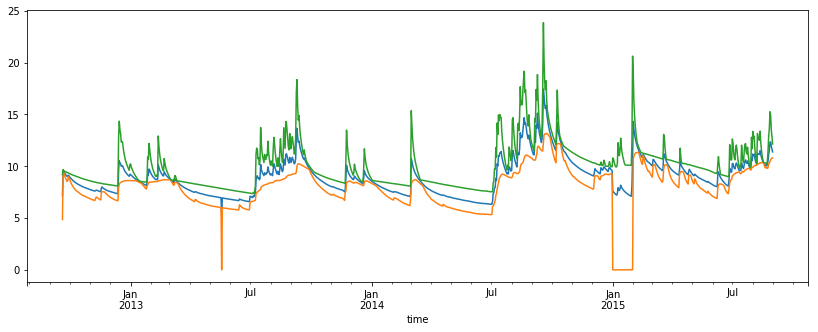

In [7]:
plt.rcParams['figure.figsize'] = [14, 5]

data["AirMOSS_L4_rootzone_mean"].plot()
data["AirMOSS_L4_rootzone_min"].plot()
data["AirMOSS_L4_rootzone_max"].plot()

In [60]:
# ----------------------------------------------------------------------------------
#df = txt_to_pd(r.text)        <- make request auth work # parse response.text to df
# temporary, remove this, auth
df = pd.read_csv("docs/daily-smap-ORNL-DAAC-hYa36V.txt", header=4, index_col="time")
df.index = pd.to_datetime(df.index)    
# ----------------------------------------------------------------------------------

dfs = {col: split_pd(df[col]) for col in df.columns}     # loop over cols and split to dfs

In [65]:
list(dfs.values())

[            Min  Mean  Max
 time                      
 1999-03-22  NaN   NaN  NaN
 1999-03-23  NaN   NaN  NaN
 1999-03-24  NaN   NaN  NaN
 1999-03-25  NaN   NaN  NaN
 1999-03-26  NaN   NaN  NaN
 1999-03-27  NaN   NaN  NaN
 1999-03-28  NaN   NaN  NaN
 1999-03-29  NaN   NaN  NaN
 1999-03-30  NaN   NaN  NaN
 1999-03-31  NaN   NaN  NaN
 1999-04-01  NaN   NaN  NaN
 1999-04-02  NaN   NaN  NaN
 1999-04-03  NaN   NaN  NaN
 1999-04-04  NaN   NaN  NaN
 1999-04-05  NaN   NaN  NaN
 1999-04-06  NaN   NaN  NaN
 1999-04-07  NaN   NaN  NaN
 1999-04-08  NaN   NaN  NaN
 1999-04-09  NaN   NaN  NaN
 1999-04-10  NaN   NaN  NaN
 1999-04-11  NaN   NaN  NaN
 1999-04-12  NaN   NaN  NaN
 1999-04-13  NaN   NaN  NaN
 1999-04-14  NaN   NaN  NaN
 1999-04-15  NaN   NaN  NaN
 1999-04-16  NaN   NaN  NaN
 1999-04-17  NaN   NaN  NaN
 1999-04-18  NaN   NaN  NaN
 1999-04-19  NaN   NaN  NaN
 1999-04-20  NaN   NaN  NaN
 ...         ...   ...  ...
 2019-02-06  NaN   NaN  NaN
 2019-02-07  NaN   NaN  NaN
 2019-02-08  NaN   N

In [58]:
def line_plotter(o):
    """ """
    o.plot()

In [ ]:
allnan = lambda v: np.count_nonzero(~np.isnan(v.data))==0
units = [
    'g m-2 d-1', 
    'm3/m3', 
    'degrees C', 
    'mm/day']

fig, axs = plt.subplots(4, 1, sharex=True, figsize=(15, 12))

for i, unit in enumerate(units):
    
    variables = pds.filter_by_attrs(units=unit)
    for v in variables:
        if v!="COSMOS_surface":
            a = pds[v]
            if not allnan(a):              
                pds[v].plot(ax=axs[i])
                axs[i].set_title(None)
                axs[i].set_xlabel(None)

---------------------------------------------
## Read USFS data from GeoJSON

The original dataset was a shapefile, but we reprojected and saved as GeoJSON using *ogr2ogr* from the GDAL/OGR binaries package available at OSGeo. GeoJSON is [a format for encoding a variety of geographic data structures](http://geojson.org/).

Let's open the GeoJSON and extract some information about one of the USFS sites. Read to a dictionary with `json.load` and print the first feature:

In [8]:
with open("sites/Sites_lf_geo.json", "r") as f:
    shapes = json.load(f)   # json load parses open json file to dict

shapes.keys()

dict_keys(['name', 'crs', 'type', 'features'])

Inspect the first three dictionary items:

In [9]:
print(shapes["crs"]) 
print(shapes["name"])
print(shapes["type"])

{'properties': {'name': 'urn:ogc:def:crs:OGC:1.3:CRS84'}, 'type': 'name'}
Sites_lf_geo
FeatureCollection


A list of geojson features is stored in the *features* element. Print the keys for the first one:

In [10]:
features = shapes["features"]
feat = features[0]

feat.keys()

dict_keys(['geometry', 'properties', 'type'])

Features have two essential pieces, *geometry* and *properties*, and a third item *type* that acknowledges that the item is a feature. The geometry contains two items: *type*, one of seven possible types, and *coordinates*, a list of coordinates that delineate the feature. Here's an example:
```
 "type": "Feature",
   "geometry": {
       "type": "Polygon",
       "coordinates": [
           [
               [100.0, 0.0],
               [101.0, 0.0],
               [101.0, 1.0],
               [100.0, 1.0],
               [100.0, 0.0]
           ]
       ]
   },
```
A feature's properties are equivalent to what you'd find in the attribute table if you were to open the file in ArcMap. Print them:

In [11]:
feat["properties"]

{'AREA': 509937500.0,
 'COUNT': 8159,
 'Count_1': 8270.0,
 'Count_10': 8274.0,
 'Count_11': 8253.0,
 'Count_12': 8256.0,
 'Count_13': 8263.0,
 'Count_14': 8268.0,
 'Count_15': 8262.0,
 'Count_16': 8234.0,
 'Count_17': 8263.0,
 'Count_18': 8268.0,
 'Count_19': 8245.0,
 'Count_2': 8269.0,
 'Count_20': 8224.0,
 'Count_21': 8272.0,
 'Count_22': 8271.0,
 'Count_23': 8252.0,
 'Count_24': 8259.0,
 'Count_25': 8269.0,
 'Count_26': 8249.0,
 'Count_27': 8240.0,
 'Count_28': 8238.0,
 'Count_29': 8247.0,
 'Count_3': 8270.0,
 'Count_30': 8234.0,
 'Count_31': 8268.0,
 'Count_32': 8266.0,
 'Count_33': 8260.0,
 'Count_34': 8219.0,
 'Count_35': 8142.0,
 'Count_4': 8271.0,
 'Count_5': 8269.0,
 'Count_6': 8257.0,
 'Count_7': 8266.0,
 'Count_8': 8273.0,
 'Count_9': 8272.0,
 'DISTRICTNA': 'Douglas Ranger District',
 'DISTRICTNU': '01',
 'DISTRICTOR': '030501',
 'FID_1': 60,
 'FORESTNAME': 'Coronado National Forest',
 'FORESTNUMB': '05',
 'GIS_ACRES': 434025.2,
 'MAJORITY': -51,
 'MAX': 34,
 'MEAN': -42.650

These values are aboveground NPP... ? Use list comprehension to collect the values for mean and standard deviation into a dictionary, and make a data frame from the dictionary:

In [12]:
stats = pd.DataFrame({
    "mean": [v for k,v in feat["properties"].items() if "MEAN" in k],
    "std": [v for k,v in feat["properties"].items() if "STD" in k]})

stats.head(5)

,mean,std
0,1432.500726,734.877816
1,1250.930847,741.431638
2,1178.960421,680.319470
3,1182.049220,813.987629
4,886.231560,721.369645


Don't print the feature's geometry, it will take up the whole page. Instead pass it to `Shapely.geometry.shape`:

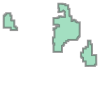

In [13]:
geom = feat["geometry"]         # geometry from feature 0
sgeom = shape(geom)             # Shapely.geometry.shape
bnds = sgeom.bounds             # bounding box around geometry
cent = sgeom.centroid           # centroid for geometry

sgeom

`Shapely` provides some convenient methods for getting important spatial metadata about the feature like its centroid and bounding coordinates. We'll use these later.

For now, we learn how to render the geometry as an [`ipyleaflet`](https://ipyleaflet.readthedocs.io/en/latest/) map layer. Create the map in four steps:
1. Get a basemap and make a tile layer to display in the map widget. You have a lot of options, including layers available through NASA GIBS: `basemaps.NASAGIBS.ModisTerraTrueColorCR` | [More information](https://ipyleaflet.readthedocs.io/en/latest/api_reference/tile_layer.html)
2. [Make a map layer from the GeoJSON feature](https://ipyleaflet.readthedocs.io/en/latest/api_reference/geo_json.html) that we explored earlier.
3. Make an [`ipyleaflet.LayerGroup`](https://ipyleaflet.readthedocs.io/en/latest/api_reference/layer_group.html) to store an array of point layers that we will generate in the next step.
4. [Initialize the map widget](https://ipyleaflet.readthedocs.io/en/latest/api_reference/map.html) with a tuple of layers, the map center and zoom level.

In [14]:
bmap = mwg.basemap_to_tiles(mwg.basemaps.Esri.WorldImagery) # 1. get a basemap
poly = mwg.GeoJSON(data=feat)                               # 2. geojson layer
points = mwg.LayerGroup()                                   # 3. points group
m1 = mwg.Map(                                               # 4. map widget init
    layers=(bmap, poly, points,),  # tuple of map layers
    center=(cent.y, cent.x),       # map center (from shapely)
    zoom=9)                        # zoom level

m1                                 # display the map

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'attribution': 'Map data (c) <a href…

## the EASE Grid

Spatial queries to the Soil Moisture Visualizer return data corresponding to 9x9-km cells within [the EASE grid system](https://nsidc.org/data/ease).

The next short section of the notebook demonstrates how to select an array coordinates that represent centroids of  EASE grid cells that fall within the boundary of the `shapely` geometry that we created earlier. The coordinates can then be used to submit a series of requests for data from the SMV.
      
The EASE grid latitudes and longitudes are stored in two binary files:
* [docs/EASE2_M09km.lats.3856x1624x1.double](docs/EASE2_M09km.lats.3856x1624x1.double)
* [docs/EASE2_M09km.lats.3856x1624x1.double](docs/EASE2_M09km.lats.3856x1624x1.double)

Read the two files to arrays with [`numpy.fromfile`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.fromfile.html), flatten them by calling [`numpy.ndarray.flatten`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.flatten.html), and stack them with [`numpy.dstack`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.dstack.html) to make one very long 2-d array of latitude, longitude pairs:

In [15]:
lats = np.fromfile("docs/EASE2_M09km.lats.3856x1624x1.double", dtype=np.float64).flatten() 
lons = np.fromfile("docs/EASE2_M09km.lons.3856x1624x1.double", dtype=np.float64).flatten()
crds = np.dstack((lats,lons))[0]

print("Array shape: "+str(crds.shape)); crds

Array shape: (6262144, 2)


array([[  84.6564188 , -179.9533195 ],
       [  84.6564188 , -179.85995851],
       [  84.6564188 , -179.76659751],
       ...,
       [ -84.6564188 ,  179.76659751],
       [ -84.6564188 ,  179.85995851],
       [ -84.6564188 ,  179.9533195 ]])

Reduce the giant array using the tuple of `bnds` that we took from the `shapely` geometry earlier:

In [16]:
ease = crds[(bnds[1]<lats)&(lats<bnds[3])&(bnds[0]<lons)&(lons<bnds[2])]

print("The new array shape: "+str(ease.shape))

The new array shape: (108, 2)


So, 108 EASE grid points fall within the minimum rectangular envelope of the geometry. That seems reasonable. Make an [`ipyleaflet.CircleMarker`](https://ipyleaflet.readthedocs.io/en/latest/api_reference/circle_marker.html) for each point and display the updated map widget:

In [17]:
for p in ease:
    pt = mwg.CircleMarker(                       # map point
        location=(p[0],p[1]),                    # lat,lon tuple
        radius=7,                                # in pixels
        stroke=False,
        fill_opacity=0.6,
        fill_color="black")
    points.add_layer(pt)
    
m1

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'attribution': 'Map data (c) <a href…

Now we should eliminate points that fall outside of the actual boundary of the polygon. `shapely.geometry.shape` objects provide a method [`object.contains`](https://shapely.readthedocs.io/en/stable/manual.html) that returns a boolean indicating whether or not it contains an input point. The next cell does the following:
1. Clear the points that we added to the map in the last cell.
2. Make a simple function `get_point` that returns a `shapely.geometry.shape` for an input lat,lon pair.
3. Iterate over the remaining EASE grid points and add to the map widget if shapely *contains* returns True.



In [18]:
def get_point(p):
    """Takes input lat,lon pair; returns a shapely point geometry."""
    s = shape({"coordinates": [p[1], p[0]], "type": "Point"})
    return(s)


points.clear_layers()                   # clear the map points
for p in ease:                          # loop over remaining EASE points
    
    spt = get_point([p[0], p[1]])       # get a shapely point
    if sgeom.contains(spt):             # if poly contains point, 
        
        pt = mwg.CircleMarker(          # make circle marker
            location=(p[0],p[1]),
            radius=7,
            stroke=False,
            fill_opacity=0.6,
            fill_color="black")
        
        points.add_layer(pt)            # add to map
        
m1

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'attribution': 'Map data (c) <a href…

Make a function that includes all of the logic above:

In [19]:
def get_ease(shapely_geom):
    """
    Takes an input shapely geometry and returns a list of EASE grid 
    lat,lon pairs that are contained within it.
    """

    bnds = shapely_geom.bounds                # bounding box of input geom
    ease = crds[
        (bnds[1]<lats) & (lats<bnds[3]) &     # ybnds < lat < ybnds
        (bnds[0]<lons) & (lons<bnds[2])]      # xbnds < lon < xbnds

    ease_reduced = []
    for p in ease:
        
        shapely_pt = shape({                  # input to shapely.shape is a
            "type": "Point",                  # python dict equivalent of
            "coordinates": (p[1], p[0])})     # geojson point geometry
        
        if shapely_geom.contains(shapely_pt): # if point inside poly
            ease_reduced.append([p[0], p[1]]) # return lat, lon tuple

    return(ease_reduced)

## Download SMV data with `requests`
Each request to SMV takes a latitude `&lt` and longitude `&ln`. This request is for (30,-100):       
https://daac.ornl.gov/cgi-bin/viz/download.pl?lt=30&ln=-100&d=smap

In [39]:
lt, ln = ease[0]                                               # first EASE point
url = "https://daac.ornl.gov/cgi-bin/viz/download.pl?"         # SMV download url
request_url = url+"lt={lt}&ln={ln}&d=smap".format(lt=lt,ln=ln) # complete request url

print("SMV base url:\t"+url); print("Full URL:\t"+request_url)

SMV base url:	https://daac.ornl.gov/cgi-bin/viz/download.pl?
Full URL:	https://daac.ornl.gov/cgi-bin/viz/download.pl?lt=32.0802909170736&ln=-110.02593360995849&d=smap


Now use [`requests.get`](https://2.python-requests.org//en/master/user/quickstart/) (*note: use `session` from the Earthdata authentication at the very beginning of the notebook*) to download the data from the URL and print the first ten lines:

In [43]:
r = requests.get(request_url, cookies=auth)
f = StringIO(r.text)

print("\n".join(f.readlines()[0:10]))

Filename: daily-smap-ORNL-DAAC-XXXXXX

Data_Set_Name: Daily soil moisture and ancillary datasets. Data columns are delineated by commas. The values in each column when separated by semicolons represent the daily range as 'min; mean; max'.

Location: 32.0802909170736, -110.02593360995849

Citation: ORNL DAAC. 2017. Soil Moisture Visualizer. ORNL DAAC, Oak Ridge, Tennessee, USA. http://dx.doi.org/10.3334/ORNLDAAC/1366





time,SoilSCAPE_surface,SoilSCAPE_rootzone,AirMOSS_L2_3_surface,AirMOSS_L2_3_rootzone,AirMOSS_L4_rootzone,SMAP_surface,SMAP_rootzone,NEE_mean,GPP_mean,prcp,tmax,tmin,ET,LST_Day,LST_Night,EVI,AirMOSS_in-ground_surface,AirMOSS_in-ground_rootzone,COSMOS_surface,COSMOS_rootzone,CRN_surface,CRN_rootzone,SCAN_surface,SCAN_rootzone,SNOTEL_surface,SNOTEL_rootzone,GRACE_surface_pctl,GRACE_rootzone_pctl

2002-04-01,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;0.72;,;2.92;

2002-04-02,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,;;,

You can use the same methods that we covered at the beginning to parse the text to a pandas data frame. We will take that one step further in the next section as we prepare to add another dimension to our SMV dataset.

## Reformat SMV data as a netCDF-like `xarray.Dataset`

Now add one more step to the **SMV download response** > **pandas data frame** > **split columns to expanded data frame** workflow by making an xarray dataset. Start with the two functions below, `txt_to_pd` and `split_pd`. They do all of the SMV data processing that we've covered to this to point: 
* convert the request response to a text object; 
* parse the text to a `pandas` data frame; and,
* parse the columns of `min;mean;max` into three new columns.

Test them on the dataset that we downloaded before:

In [44]:
def txt_to_pd(response_text):
    """Parses response.text to data frame with date index."""
    
    f = StringIO(response_text)                          # get file from string
    df = pd.read_csv(f, header=4, index_col="time")      # read to df
    df.index = pd.to_datetime(df.index)                  # convert index to dates
    
    return(df)


def split_pd(col):
    """Splits pd column by ; and set all values to float, nan."""
    
    df = col.str.split(";",n=2,expand=True)              # split col by ;
    df = df.replace('', np.nan)                          # set '' to nan
    df = df.astype(float)                                # set all to float
    df.columns = ["Min","Mean","Max"]                    # add column names
    
    return(df)

# ----------------------------------------------------------------------------------
#df = txt_to_pd(r.text)        <- make request auth work # parse response.text to df
# temporary, remove this, auth
df = pd.read_csv("docs/daily-smap-ORNL-DAAC-hYa36V.txt", header=4, index_col="time")
df.index = pd.to_datetime(df.index)    
# ----------------------------------------------------------------------------------

dfs = {col: split_pd(df[col]) for col in df.columns}     # loop over cols and split to dfs

The two `xarray` data structures, [`xarray.DataArray`](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.html#xarray.DataArray) and [`xarray.Dataset`](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.html#xarray.Dataset), are so closely tied to the [`pandas.Series`](http://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.html#pandas.Series) and [`pandas.DataFrame`](http://pandas.pydata.org/pandas-docs/stable/reference/frame.html) that both modules provide methods to convert between them. I copied their blurb because I'm such a fan: 

>**xarray** is an open source project and Python package that makes working with labelled multi-dimensional arrays simple, efficient, and fun! xarray introduces labels in the form of dimensions, coordinates and attributes on top of raw NumPy-like arrays, which allows for a more intuitive, more concise, and less error-prone developer experience. The package includes a large and growing library of domain-agnostic functions for advanced analytics and visualization with these data structures. xarray was inspired by and borrows heavily from pandas, the popular data analysis package focused on labelled tabular data. It is particularly tailored to working with netCDF files, which were the source of xarray’s data model, and integrates tightly with dask for parallel computing.

We need to define the dimensions of our data in order to take full advantage of the features of `xarray`. We do that by making *coordinate* variables that allow for practical indexing of the data along said dimensions. For example, this cell demonstrates how to create three [`xarray.DataArrays`](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.html#xarray.DataArray) that represent:
1. the sample dimension --- remember the array of EASE grid points? a dimension to describe the spatial relationship between the different sample datasets will make it easier to summarize the data going forward.
2. the latitude dimension, and
3. the longitude dimension --- these two are self-explanatory; the latitude and longitude values are arranged along the sample dimension, one pair per sample, to describe the position in space of each sample.

In [45]:
latatts = dict(                                     # CF attributes for latitude
    standard_name="latitude",
    long_name="sample latitude",
    units="degrees_north")

lonatts = dict(                                     # CF attributes for longitude
    standard_name="latitude",
    long_name="sample latitude",
    units="degrees_north")

s = xr.DataArray(data=[1], dims=["sample"])                                  # 1. 
latarr = xr.DataArray(data=[lt], coords=[s], dims=["sample"], attrs=latatts) # 2.
lonarr = xr.DataArray(data=[ln], coords=[s], dims=["sample"], attrs=lonatts) # 3. 

latarr

<xarray.DataArray (sample: 1)>
array([32.080291])
Coordinates:
  * sample   (sample) int64 1
Attributes:
    units:          degrees_north
    long_name:      sample latitude
    standard_name:  latitude

The resulting latitude array is very simple, with only one value. 

The function below converts SMV outputs (as data frames) to an `xarray.DataArray` with three dimensions: the sample dimension (length=1), the time dimension (length=n), and the *stat* dimension, which really only exists because it allows us to keep all of the data in one place. Steps:

1. Collect from the SMV datasets table a list of attributes to assign to the array; 
2. convert the `pandas.DataFrame` to an the `xarray` structure; 
3. rename the automatically-generated dimension to "stat"; and, 
4. set a new attribute that indicates whether or not the dataset has valid observations; "allnan"==0 indicates there are valid data and vice versa

In [48]:
def pd_to_xr(dataset, df):
    """Makes an xr.Dataset from a pandas column (series) and coords."""
    
    a = smvds.loc[dataset].to_dict()                        # 1.
    x = xr.DataArray(df, name=dataset, attrs=a)             # 2.
    x = x.rename(dict(dim_1="stat"))                        # 3.
    x.attrs["allnan"] = int(np.isnan(np.nanmean(x.data)))   # 4.
    
    return(x)

Loop over the dictionary of data frames, here's the first one:

In [50]:
ds = {c: pd_to_xr(c,d) for c,d in dfs.items()}
xds = xr.merge(ds.values())
xds = xds.assign_coords(lat=latarr, lon=lonarr)
xdsp = xds[""]
xds

/home/jack/.local/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys


<xarray.Dataset>
Dimensions:                     (sample: 1, stat: 3, time: 7291)
Coordinates:
  * time                        (time) datetime64[ns] 1999-03-22 ... 2019-03-07
  * stat                        (stat) object 'Min' 'Mean' 'Max'
  * sample                      (sample) int64 1
    lat                         (sample) float64 32.08
    lon                         (sample) float64 -110.0
Data variables:
    ET                          (time, stat) float64 nan nan nan ... nan nan nan
    FLUXNET_surface             (time, stat) float64 nan nan nan ... nan nan nan
    COSMOS_surface              (time, stat) float64 nan nan nan ... nan nan nan
    LST_Day                     (time, stat) float64 nan nan nan ... nan nan nan
    AirMOSS_L2_3_surface        (time, stat) float64 nan nan nan ... nan nan nan
    SoilSCAPE_surface           (time, stat) float64 nan nan nan ... 9.58 32.84
    GRACE_surface_pctl          (time, stat) float64 nan nan nan ... nan nan nan
    SCAN_rootzone 

And this is what a single SMV dataset looks like:

In [51]:
xds["SMAP_surface"]

<xarray.DataArray 'SMAP_surface' (time: 7291, stat: 3)>
array([[nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       ...,
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan]])
Coordinates:
  * time     (time) datetime64[ns] 1999-03-22 1999-03-23 ... 2019-03-07
  * stat     (stat) object 'Min' 'Mean' 'Max'
Attributes:
    soil_zone:      surface
    native_res:     9000-m 
    soil_depth:     0-5, 0-100 cm
    type:           spaceborne
    units:          m3/m3
    source:         SMAP
    time_coverage:  2015-present
    description:    Mean vol (%) soil moisture at 0-5cm 
    allnan:         0

In some cases it may be advantageous to reorder the dimensions over which the data are arranged. You can transpose the 2-d array with [`xarray.Dataset.transpose`](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.transpose.html):

```
xdsT = xds.transpose()
```

### Get the "plottable" datasets
Remember that we added an attribute to each SMV dataset that indicates whether or not the mean\*min\*max array is entirely nodata: *allnan*

Exclude SMV datasets that are entirely nodata using [`xarray.Dataset.filter_by_attrs`](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.filter_by_attrs.html#xarray.Dataset.filter_by_attrs):

In [52]:
pds = xds.filter_by_attrs(allnan=0).sel(stat="Mean")
pds

<xarray.Dataset>
Dimensions:                (time: 7291)
Coordinates:
  * time                   (time) datetime64[ns] 1999-03-22 ... 2019-03-07
    stat                   <U4 'Mean'
Data variables:
    FLUXNET_surface        (time) float64 nan nan nan nan ... nan nan nan nan
    COSMOS_surface         (time) float64 nan nan nan nan ... nan nan nan nan
    LST_Day                (time) float64 nan nan nan nan ... nan nan nan nan
    AirMOSS_L2_3_surface   (time) float64 nan nan nan nan ... nan nan nan nan
    SoilSCAPE_surface      (time) float64 nan nan nan nan ... 16.68 14.23 9.58
    GRACE_surface_pctl     (time) float64 nan nan nan nan ... nan nan nan nan
    SCAN_rootzone          (time) float64 5.5 5.6 6.0 5.72 ... nan nan nan nan
    SMAP_surface           (time) float64 nan nan nan nan ... nan nan nan nan
    tmin                   (time) float64 4.0 5.18 4.34 5.0 ... nan nan nan nan
    SoilSCAPE_rootzone     (time) float64 nan nan nan nan ... 16.29 15.78 14.51
    FLUXNET_roo

In [53]:
pds.filter_by_attrs(units="m3/m3")

<xarray.Dataset>
Dimensions:                (time: 7291)
Coordinates:
  * time                   (time) datetime64[ns] 1999-03-22 ... 2019-03-07
    stat                   <U4 'Mean'
Data variables:
    FLUXNET_surface        (time) float64 nan nan nan nan ... nan nan nan nan
    COSMOS_surface         (time) float64 nan nan nan nan ... nan nan nan nan
    AirMOSS_L2_3_surface   (time) float64 nan nan nan nan ... nan nan nan nan
    SoilSCAPE_surface      (time) float64 nan nan nan nan ... 16.68 14.23 9.58
    SCAN_rootzone          (time) float64 5.5 5.6 6.0 5.72 ... nan nan nan nan
    SMAP_surface           (time) float64 nan nan nan nan ... nan nan nan nan
    SoilSCAPE_rootzone     (time) float64 nan nan nan nan ... 16.29 15.78 14.51
    FLUXNET_rootzone       (time) float64 nan nan nan nan ... nan nan nan nan
    COSMOS_rootzone        (time) float64 nan nan nan nan ... nan nan nan nan
    AirMOSS_L2_3_rootzone  (time) float64 nan nan nan nan ... nan nan nan nan
    AirMOSS_L4_ro

In [54]:
units = list(set([pds[d].attrs["units"] for d in pds]))
print(units)

['%', 'm3/m3', 'unitless', 'degrees C', 'mm/day', 'g m-2 d-1', 'K/8day']


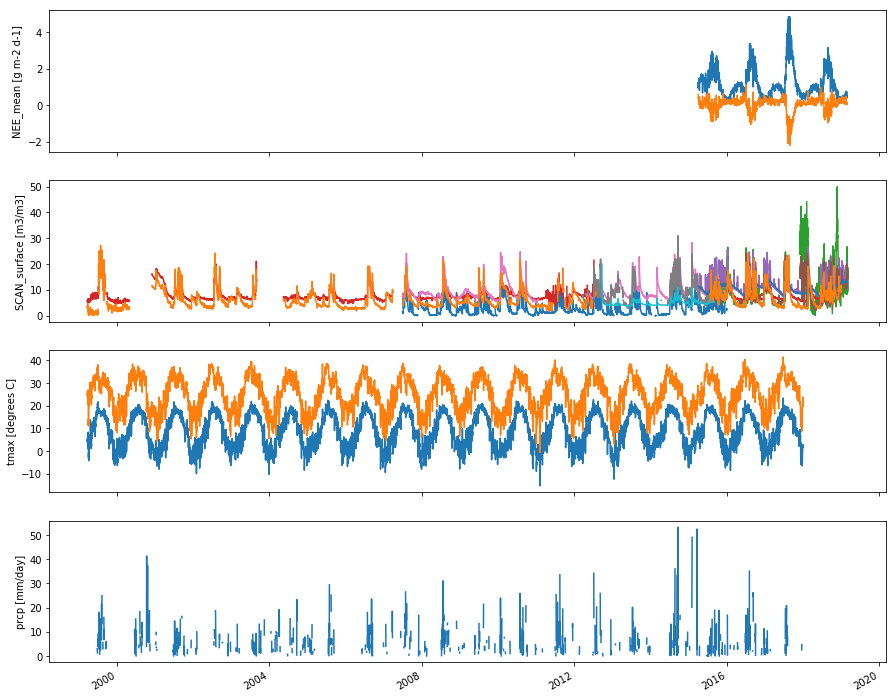

In [57]:
allnan = lambda v: np.count_nonzero(~np.isnan(v.data))==0
units = [
    'g m-2 d-1', 
    'm3/m3', 
    'degrees C', 
    'mm/day']

fig, axs = plt.subplots(4, 1, sharex=True, figsize=(15, 12))

for i, unit in enumerate(units):
    
    variables = pds.filter_by_attrs(units=unit)
    for v in variables:
        if v!="COSMOS_surface":
            a = pds[v]
            if not allnan(a):              
                pds[v].plot(ax=axs[i])
                axs[i].set_title(None)
                axs[i].set_xlabel(None)

We can also filter by any of the other attribute(s) that we assigned from the SMV datasets table:

In [ ]:
pds.filter_by_attrs(source="SMAP", soil_zone="rootzone")

### Slice/filter using dimension-based criteria
Filter by the *stat* dimension:

In [ ]:
pds.sel(stat="mean")

or the *time* dimension:

In [ ]:
time = pds.time.data
print(time[10]); print(time[20])

pds.sel(time=slice(time[10],time[20]))

This feature becomes more useful as you add more dimensions to your dataset. We'll use it to filter across three dimensions once we add more sample locations to this dataset.

In [ ]:
pds["SMAP_surface"]

## Make a simple interactive plotting UI
We use the logic above to drive the plotting UI. We can get a list of the attributes to filter by using list comprehension:

In [ ]:
source = list(set([pds[d].attrs["source"] for d in pds]))
stype = list(set([pds[d].attrs["type"] for d in pds]))
soil_zone = list(set([pds[d].attrs["soil_zone"] for d in pds]))

print(source); print(stype); print(soil_zone)

GRACE has very few observations, so we don't really need the source filter. And all data are from spaceborne datasets, so the only relevant attribute filter for this dataset is the *soil_zone*:

In [ ]:
dates = pds.sel(stat="mean").dropna(dim="time", how="all").time.data
dates = dates.astype('M8[D]')

time_slider = wg.SelectionRangeSlider(
    options=dates, 
    index=(0, len(dates)-1),
    continuous_update=False,
    layout=wg.Layout(width="auto"))

widgets = dict(
    Time=time_slider, 
    By=["None", "year", "month", "week", "day"],
    Zone=['surface', 'rootzone'],
    Mean=True, Min=True, Max=True)

# needs to run twice to switch from inline -->
%matplotlib notebook

Build and display the plot ui:

In [ ]:
%matplotlib notebook
plt.rcParams['figure.figsize'] = [12, 5]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)


def update(Time, By, Zone, Mean, Min, Max):
    """ """

    stat = [True]*3 if not any([Mean,Min,Max]) else [Mean,Min,Max]
    data = pds.sel(stat=stat)                      # filter by stats
    
    data = data.filter_by_attrs(soil_zone=Zone)    # filter by attributes

    data = data.sel(time=slice(Time[0],Time[1]))   # filter by time;
    
    xaxis = "time" if By == "None" else By         # new plot interval
    if By is not "None":
        data = data.sel(stat="mean")
        data = data.groupby("time."+str(By)).mean()

    ax.clear()                                     # clear plot
    for d in data:                                 # loop over vars
        data[d].plot.line(x=xaxis, ax=ax)          # add line
    fig.canvas.draw()                              # draw 


p = wg.interactive(update, **widgets);
display(p)

## Organize a series of SMV samples into similar structure

The capabilities of xarray aren't obvious until you add a second dimension to the data (excluding the unnecessary *stats* dim). You can do everything we just did with pandas. Let's look at our USFS polygon again with a new map:

In [ ]:
points = mwg.LayerGroup()
polys = mwg.LayerGroup(layers=(poly,))
m2 = mwg.Map(layers=(polys, points, bmap), center=(cent.y, cent.x), zoom=9)

m2

### Container for point samples
`Sample(<id>,<lat>,<lon>)`
* id: an integer id unique to the sample within it's input polygon
* lat, lon: latitude, longitude numerics

In [ ]:
url = "https://daac.ornl.gov/cgi-bin/viz/download.pl?"

class Sample(object):

    def __init__(self, i, lat, lon):
        """Inits with id,lat,lon; makes request string, map point."""
        self.id, self.lat, self.lon = i, lat, lon               # id, lat, lon
        self.rurl = url+"lt={0}&ln={1}&d=smap".format(lt,ln)    # request url     
        self.pt = mwg.CircleMarker(                             # map point
            location=(lat,lon),                                 # lat,lon tuple
            radius=7,                                           # in pixels
            stroke=False,
            fill_opacity=0.6,
            fill_color="black")

    def update(self, **kwargs):
        for arg, val in kwargs.items():
            setattr(self.pt, arg, val)
        
    def submit(self):
        """Called by parent. Downloads url. Updates status."""
        self.response = requests.get(self.rurl, cookies=auth)   # submit SMV request
        self.df = txt_to_pd(self.response.text)                 # read to pandas df

Use the function we made before `get_ease` to get a list of EASE points inside the polygon, make a Sample for each, and organize inside a data frame. Print the first five rows of the data frame and display the updated map:

In [ ]:
samples = []
for i, pt in enumerate(get_ease(sgeom)):
    s = Sample(i, pt[0], pt[1])                # make a Sample instance
    points.add_layer(s.pt)                     # add map pt to points group
    samples.append((i, pt[0], pt[1], s, None)) # append tuple to the list

samples = pd.DataFrame(                        # convert list of tuples to df
    samples, 
    columns=["id", "lat", "lon", "samp", "xr"])

print(samples.head(5)); m2                     # display

Add a couple more widgets purely for aesthetics:

In [ ]:
n = len(samples.samp)
progress = wg.IntProgress(value=0, min=0, max=n, description="Progress: ", layout=wg.Layout(width="95%"))

def submit_handler(b):
    submit.disabled = True               # disable submit button
    for samp in samples.samp:            # loop over sample pts
        progress.value += 1              # update progress bar
        samp.update(                     # update point style
            stroke=True, 
            color="white", 
            opacity=0.6)
        samp.submit()                    # download the data

submit = wg.Button(description='Submit', button_style='success')
submit.on_click(submit_handler)

wg.VBox([m2,wg.HBox([submit,progress])])

Hopefully you didn't have any trouble downloading the data. Remember we made the class that binds a map marker to several other items including a pandas data frame that gets created when the sample is retrieved from the SMV.

Check the data frame for sample zero:

In [ ]:
samples0 = samples.iloc[0]
print(samples0); samples0.samp.df.tail(5)

This looks familiar. Use the steps that we learned before to convert to an xarray dataset:

In [ ]:
s0 = xr.DataArray(data=[samples0.id], dims=["sample"])
y0 = xr.DataArray(data=[samples0.lat], coords=[s0], dims=["sample"], attrs=latatts)
x0 = xr.DataArray(data=[samples0.lon], coords=[s0], dims=["sample"], attrs=lonatts)

df0 = samples0.samp.df                                  # get the sample df
dfs0 = {col: split_pd(df0[col]) for col in df0.columns} # loop over cols and split to dfs
ds0 = {c: pd_to_xr(c,d) for c,d in dfs0.items()}        # make xr datasets for each smv
xds0 = xr.merge(ds0.values())                           # merge to one xr dataset
xds0 = xds0.assign_coords(lat=y0, lon=x0)               # add coordinate arrays sample 
xds0

While we're at it, wrap all of that up in a function to apply to all of the samples:

In [ ]:
def get_sample_xr(samp):
    """ """
    
    # get sample, lat, lon xr arrays
    s = xr.DataArray(data=[samp.id], dims=["sample"])
    y = xr.DataArray(data=[samp.lat], coords=[s], dims=["sample"], attrs=latatts)
    x = xr.DataArray(data=[samp.lon], coords=[s], dims=["sample"], attrs=lonatts)

    df = samp.df                                         # get the sample df
    dfs = {col: split_pd(df[col]) for col in df.columns} # loop over cols and split to dfs
    ds = {c: pd_to_xr(c,d) for c,d in dfs.items()}       # make xr datasets for each smv
    xds = xr.merge(ds.values())                          # merge to one xr dataset
    xds = xds.assign_coords(lat=y, lon=x)                # add coordinate arrays
    
    return(xds)
    

for ix, row in samples.iterrows():                       # loop over samples df
    samples.at[ix, "xr"] = get_sample_xr(row.samp)       # add xr dataset to col
    
samples

Check sample ten:

In [ ]:
samples.iloc[10].xr

Hopefully, if we organized the data correctly, we can concatenate along the sample dimension:

In [ ]:
xds0 = xr.concat(samples.xr.tolist(), "sample")
xds0

Save as a netCDF. The dataset needs another variable and some special attributes to comply with CF (explain CF):
* a variable that describes the sequence that makes up the sample dimension
* a dataset-level attribute that inidcates the dataset's *featureType*

In [ ]:
# loop over sample dim sequence and make strings like: "sample##"
sample_name_data = ["sample"+("%02d" % s) for s in xds0.sample.data]

xds0["sample_name"] = xr.DataArray(        # make an xr array
    data=sample_name_data, 
    dims=["sample"], 
    attrs=dict(                            # cf attributes
        long_name="sample name", 
        cf_role="timeseries_id"))

xds0.attrs.update({
    "convention": "CF-1.6", 
    "featureType": "timeSeries",
    "source": "Soil Moisture Visualizer",
    "institution": "Oak Ridge National Laboratory Distributed Active Archive Center"})

xds0

Save with [`xarray.Dataset.to_netcdf`](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.to_netcdf.html#xarray.Dataset.to_netcdf):

In [ ]:
xds0.to_netcdf("23samples.nc")

## Extend the plotting UI
We probably have more options for filters with a dataset this size. Let's see:

In [ ]:
xpds = xds0.filter_by_attrs(allnan=0)
xpds

## better colors
1. use [`numpy.linspace`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linspace.html) to make an array of evenly-spaced values between 0-1 
2. map values to **Set3** in [`matplotlib.cm`](https://matplotlib.org/api/cm_api.html) | [colormap reference](https://matplotlib.org/gallery/color/colormap_reference.html)
3. convert to hexadecimal with [`matplotlib.colors.to_hex`](https://matplotlib.org/api/_as_gen/matplotlib.colors.to_hex.html#matplotlib.colors.to_hex)

In [ ]:
cspace = np.linspace(0.0, 1.0, len(features)) # 1
rgb = cm.Set3(cspace)                         # 2
cols = [colors.to_hex(c[0:3]) for c in rgb]   # 3

cols

MAybe give them the option to import shapefile?
```
with open("sites/Sites_lf_geo.json", "r") as f:
    shapes = json.load(f)
features = shapes["features"]
```


In [ ]:
m1,m2,s0,df0,dfs0,xds0,samples = None,None,None,None,None,None,None
# -----------------------------------------------------------------

site_details = """
{FORESTNAME} ({FORESTNUMB})
{DISTRICTNA} ({DISTRICTNU})
REGION:   {REGION}
ACRES:    {GIS_ACRES}
MIN:      {MIN}
MEDIAN:   {MEDIAN}
MAX:      {MAX}
RANGE:    {RANGE}
SUM:      {SUM}
VARIETY:  {VARIETY}
MINORITY: {MINORITY}
MAJORITY: {MAJORITY}
COUNT:    {COUNT}
"""

out_style = dict(width="30%", height="400px", overflow_y="scroll", overflow_x="hidden", border="1px solid gray")
out = Output(layout=Layout(**out_style))

out.clear_output()
with out:
    print(site_details.format(**lo.site))

In [ ]:
import ipywidgets as wg
import ipyleaflet as mwg
from ipywidgets import Layout, Button, IntProgress, Output, HBox, VBox, HTML
from ipyleaflet import Map, LayerGroup, GeoJSON, CircleMarker

basemap = mwg.basemap_to_tiles(mwg.basemaps.Esri.WorldImagery)
polys = LayerGroup()
points = LayerGroup()

map_center = (32.75, -109)
mapw = Map(
    layers=(basemap, polys, points,), 
    center=map_center, 
    zoom=7, 
    scroll_wheel_zoom=True)

submit = Button( 
    description='Submit', 
    disabled=True, 
    button_style='success')

progress = IntProgress(
    description="Progress: ", 
    layout=Layout(width="95%"))

ui = VBox([mapw, HBox([submit, progress])])

Sample class, few small changes:

In [ ]:
# ----------------------------------------------------------------------------
url = "https://daac.ornl.gov/cgi-bin/viz/download.pl?"

pt_style = dict(radius=7, fill_opacity=0.6, fill_color="black", stroke=False)
pt_status_on = dict(stroke=True, color="white", opacity=0.6)
pt_status_off = dict(stroke=False, color="black", opacity=0.6)


class Sample(object):

    def __init__(self, i, lat, lon):
        """Inits with id,lat,lon; makes request string, map point."""
        self.id, self.lat, self.lon = i, lat, lon
        self.rurl = url+"lt={0}&ln={1}&d=smap".format(lat,lon)  # request url
        self.pt = CircleMarker(location=(lat, lon), **pt_style) # map point
        self.on = False                                         # on/off status

    def update(self, **kwargs):
        for arg, val in kwargs.items():
            setattr(self.pt, arg, val)
    
    def toggle(self, event, type, coordinates):
        opac = 0.1 if self.on else 0.6
        self.update(opacity=opac)
        self.on = False if self.on else True
        
    def submit(self):
        """Called by parent. Downloads url. Updates status."""
        self.response = requests.get(self.rurl, cookies=auth)   # submit SMV request
        self.df = txt_to_pd(self.response.text)                 # read to pandas df
        self.xr = get_sample_xr(self)                           # get xarray dataset
        self.pt.on_click(self.toggle)                           # callback on click
        self.on = True                                          # toggle on

# ----------------------------------------------------------------------------
lyr_style = lambda c: {"color": c, "fillColor": c, "weight": 1, "fillOpacity": 0.4}
lyr_hstyle = {"color": "white", "fillOpacity": 0.8}
statcheck = lambda k: k.split("_")[0] not in ["MEAN","STD","Count", "style"]


def mgeo(i, feat, col):
    feat["properties"].update({
        "id": i, 
        "style": lyr_style(col)})
    return(dict(data=feat, hover_style=lyr_hstyle))


class Layer(object):

    def __init__(self, i, feat, col=None):
        """Inits with id,lat,lon; makes request string, map point."""
        self.id = i
        self.feat = feat
        
        self.sgeom = shape(feat["geometry"])
        self.ease = get_ease(self.sgeom)                        # get ease points
        self.cent = self.sgeom.centroid                         # get centroid
        self.lat, self.lon = self.cent.y, self.cent.x           # get lat, lon
        
        prop = feat["properties"]
        mean = [v for k,v in prop.items() if "MEAN" in k]
        std = [v for k,v in prop.items() if "STD" in k]
        self.stats = pd.DataFrame({"mean": mean, "std": std})
        self.site = {k:v for k,v in prop.items() if statcheck(k)}
        
        lyr = mgeo(i, feat, col)
        self.layer = GeoJSON(**lyr)
        self.layer.on_click(self.toggle)

        self.on, self.dl = False, False                    # on/off, dl status
        
    def update(self, **kwargs):
        for arg, val in kwargs.items():
            setattr(self.layer, arg, val)
    
    def toggle(self, **kwargs):
        """Routine for when a new USFS polygon is selected."""
        if list(kwargs.keys()) != ['event', 'properties']: # check event
            return(None)                                   # skip basemap
        self.on = False if self.on else True               # update status

In [ ]:
prog = lambda m: dict(min=0, max=m, value=0)
xrds = lambda l: xr.concat([s.xr for s in l], "sample")


def get_on_lyrs(column=None):
    """
    Returns a subset of layers df, only "on" layers. If keyword 
    argument 'column' will return only that column.
    """
    on = [i for i,row in layers.iterrows() if row["layer"].on]
    sdf = layers.iloc[on][column] if column else layers.iloc[on]
    return(sdf)


def submit_handler(b):
    """Resets UI and sends requests to SMV when new submit."""
    
    lyron = get_on_lyrs()
    for i, row in lyron.iterrows():             # loop over samples col
        if not row["layer"].dl:                 # if not downloaded yet
            samp = row.samples["samp"].tolist() # get samples
            for a,v in prog(len(samp)).items(): # reset progress bar
                setattr(progress, a, v)
            for s in samp:                      # loop over sample pts
                progress.value += 1             # update progress bar
                s.update(**pt_status_on)        # update style
                s.submit()                      # download the data
            layers.at[i,"xr"] = xrds(samp)      # make xr dataset
            row["layer"].dl = True              # set dl status to True
    submit.disabled = True                      # disable submit button

submit.on_click(submit_handler)

# ----------------------------------------------------------------------------

def layer_click_handler(**kwargs): 
    """
    Routine for when a new USFS polygon is selected. Layer.toggle
    internal updater should evaluate first.
    """
    if list(kwargs.keys()) != ['event', 'properties']: # check event
         return(None)                         # skip basemap
    i = int(kwargs["properties"]["id"])       # set selected poly id
    l = layers.iloc[i]                        # get row for selected
    lo = l.layer                              # get Layer class inst
    pteval = points.add_layer if lo.on else points.remove_layer
    pteval(l["points"])                       # update layer status;
    submit.disabled = True if len(get_on_lyrs())==0 else False
    if lo.on:
        mapw.center, mapw.zoom = (lo.lat,lo.lon), 9 # ctr,zoom map

### Make all layers and add to map widget

In [ ]:
sample_header = ["id","lat","lon","samp"]
layer_header = ["id","lat","lon","layer","samples","points","xr"]

layers = []                                   # a temporary list 
for i, feat in enumerate(features):           # loops over USFS poly feats
    
    poly = Layer(i, feat, cols[i])            # get Layer class
    poly.layer.on_click(layer_click_handler)  # set global callback
    polys.add_layer(poly.layer)               # add to polys layer group

    pts, samps = LayerGroup(), []             # points layer group; Samples
    for j, p in enumerate(poly.ease):         # loop over EASE grid pts
        s = Sample(j, p[0], p[1])             # make a Sample instance
        pts.add_layer(s.pt)                   # add to points layer group
        samps.append((j, p[0], p[1], s))      # append tuple to the list  
        
    samps = pd.DataFrame(samps, columns=sample_header)       # samples df
    layers.append((i,poly.lat,poly.lon,poly,samps,pts,None)) # append
    
layers = pd.DataFrame(layers, columns=layer_header)          # layers df

In [ ]:
ui